# KNN Hand written letters recognition

### The below should only be run once, since this heavily uses memory, since datasize is 800mb 

In [1]:
import csv
import numpy as np
import string

##We needed to include skipDataParam otherwise dataset is too large for my system memory
def extractHandWrittenLettersFromCSV(csv_File_Path,skipData):
    global targetArray
    pictureArray=[]
    alphabets_mapper = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'o',15:'p',16:'q',17:'r',18:'s',19:'t',20:'u',21:'v',22:'w',23:'x',24:'y',25:'z'}
    with open(csv_File_Path,newline="") as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|',quoting=csv.QUOTE_NONNUMERIC)
        counter = 0
        for row in reader:
            if(counter==skipData):
                digit_name=row.pop(0)
                targetArray.append(alphabets_mapper[int(digit_name)])
                pictureArray.append(np.asarray(row))
                counter=0
            counter=counter+1
    return np.asarray(pictureArray)
    
targetArray=[]
pictureArray = extractHandWrittenLettersFromCSV("../HandWrittenLettersAlignmentFixed/A_ZHandwrittenCharacters.csv",7)##Only getting every 7th letter since dataset is very large
print(len(targetArray))
print(pictureArray.shape)

53207
(53207, 784)


# General Functions

In [2]:
##Note the new images are 28x28
## For image recognition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

##For image analysis
from skimage.io import imread
from skimage.transform import resize

##Library for extracting all images in a directory
import glob
import sys


## CONSTANTS
folder_strings = 'abcdefghijklmnopqrstuvwxyz'
smallestNumberOfElementsInEachCollection=sys.maxsize;

def printArrayImage(dataImage,letterArray,index):
    if(len(dataImage.shape)<=2):
        overall=[]
        temp = []
        counter = 0
        for x in range(len(dataImage[index])):
            temp.append(dataImage[index][x])
            counter=counter+1
            if(counter==28):
                overall.append(temp)
                counter=0
                temp=[]
            
        overall=np.asarray(overall)
        plt.imshow(overall, cmap='Greys', vmin=0, vmax=255)
        plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
        plt.show()
        print(f"Letter: {letterArray[index]}")
        return
    
    plt.imshow(dataImage[index], cmap='as_gray', vmin=0, vmax=255)
    plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
    plt.show()
    
def printImage(dataImage):
    print(dataImage)
#     if(len(dataImage.shape)<=2):
#         overall=[]
#         temp = []
#         counter = 0
#         for x in range(len(dataImage[index])):
#             temp.append(dataImage[index][x])
#             counter=counter+1
#             if(counter==28):
#                 overall.append(temp)
#                 counter=0
#                 temp=[]
            
#         overall=np.asarray(overall)
#         plt.imshow(overall, cmap='Greys', vmin=0, vmax=255)
#         plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
#         plt.show()
#         print(f"Letter: {letterArray[index]}")
#         return
    
    plt.imshow(dataImage, cmap='as_gray', vmin=0, vmax=255)
    plt.show()

def printAllImagesInDataSetWithPrediction(dataImage,letterArray,model,printImageToScreen=True,skip=0):
    local=smallestNumberOfElementsInEachCollection
    if(skip>0):
        local=skip
    print(len(dataImage))
    for x in range(0,len(dataImage),local):
        if(printImageToScreen):
            printImage(lettersArray,lettersTarget,x)
        print(f"The Model predicted {model.predict(lettersArray[x].reshape(1,-1))}, actual {lettersTarget[x]}")


## Extracting testing data

In [3]:

## For image recognition
import matplotlib.cm as cm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

##For image analysis
from skimage.io import imread as mainImageRead
from skimage.transform import resize
from scipy.misc import imread, imresize, imsave
from skimage.morphology import label
from skimage.measure import regionprops
##Custom skimage improt below
from scipy.ndimage.filters import gaussian_filter
import skimage as skimage
import skimage.segmentation as segment

##Library for extracting all images in a directory
import glob
import re


class Extract_Letters:
    def extractFile(self, image):
        #         image = imread(filename, 1)

        # apply threshold in order to make the image binary
        bw = image < 120

        # remove artifacts connected to image border
        cleared = bw.copy()
        segment.clear_border(cleared)

#         # label image regions
        label_image = label(cleared, neighbors=4)
        borders = np.logical_xor(bw, cleared)
        label_image[borders] = -1
        
        letters = list()
        order = list()

        for region in regionprops(label_image):
            minr, minc, maxr, maxc = region.bbox
            # skip small images
            if region.area > 0:
#             if maxr - minr > len(image) / 250:##175 MAKES IT IDEAL FOR DATA EXTRACTION!
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                order.append(region.bbox)

        # sort the detected characters left->right, top->bottom
        lines = list()
        first_in_line = ''
        counter = 0

        # worst case scenario there can be 1 character per line
        for x in range(len(order)):
            lines.append([])

        for character in order:
            if first_in_line == '':
                first_in_line = character
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) < (first_in_line[2] - first_in_line[0]):
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) > (first_in_line[2] - first_in_line[0]):
                first_in_line = character
                counter += 1
                lines[counter].append(character)

        for x in range(len(lines)):
            lines[x].sort(key=lambda tup: tup[1])

        final = list()
        prev_tr = 0
        prev_line_br = 0

        for i in range(len(lines)):
            for j in range(len(lines[i])):
                tl_2 = lines[i][j][1]
                bl_2 = lines[i][j][0]
                if tl_2 > prev_tr and bl_2 > prev_line_br:
                    tl, tr, bl, br = lines[i][j]
                    letter_raw = bw[tl:bl, tr:br]
                    letter_norm = resize(letter_raw, (20, 20))
                    final.append(letter_norm)
                    prev_tr = lines[i][j][3]
                if j == (len(lines[i]) - 1):
                    prev_line_br = lines[i][j][2]
            prev_tr = 0
            tl_2 = 0
            ##print ('Characters recognized: ' + str(len(final)))
        print(f"Totally recognised {len(final)} characters")
        final = convertTestDataToDimensionOfTraining(final)
        return final
    
    
    def extractFileWord(self, filename):
        image = imread(filename, 1)

        # apply threshold in order to make the image binary
        bw = (image > 120).astype(np.float)

        # remove artifacts connected to image border
        cleared = bw.copy()
        cleared = gaussian_filter(cleared, (0,3))
        cleared = cleared < 1
        segment.clear_border(cleared)

        # clear_border(cleared)

#         # label image regions
        label_image = label(cleared, neighbors=4)
        borders = np.logical_xor(bw, cleared)
        label_image[borders] = -1

        letters = list()
        order = list()

        for region in regionprops(label_image):
            minr, minc, maxr, maxc = region.bbox
            # skip small images
#             if region.area > 40:
            if region.area > 200:##175 MAKES IT IDEAL FOR DATA EXTRACTION!
                rect = mpatches.Rectangle((minc, minr), (maxc - minc), (maxr - minr),
                                          fill=False, edgecolor='red', linewidth=2)
                order.append((minr-4, minc+4, maxr+4, maxc-4))

        # sort the detected characters left->right, top->bottom
        lines = list()
        first_in_line = ''
        counter = 0

        # worst case scenario there can be 1 character per line
        for x in range(len(order)):
            lines.append([])

        for character in order:
            if first_in_line == '':
                first_in_line = character
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) < (first_in_line[2] - first_in_line[0]):
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) > (first_in_line[2] - first_in_line[0]):
                first_in_line = character
                counter += 1
                lines[counter].append(character)

        for x in range(len(lines)):
            lines[x].sort(key=lambda tup: tup[1])

        final = list()
        prev_tr = 0
        prev_line_br = 0

        for i in range(len(lines)):
            for j in range(len(lines[i])):
                tl_2 = lines[i][j][1]
                bl_2 = lines[i][j][0]
                if tl_2 > prev_tr and bl_2 > prev_line_br:
                    tl, tr, bl, br = lines[i][j]
                    letter_raw = bw[tl:bl, tr:br]
                    final.append(letter_raw)
                    prev_tr = lines[i][j][3]
                if j == (len(lines[i]) - 1):
                    prev_line_br = lines[i][j][2]
            prev_tr = 0
            tl_2 = 0
            ##print ('Characters recognized: ' + str(len(final)))
        print(f"Totally recognised {len(final)} characters")
        
        return final
    
    def __init__(self):
        print("Extracting characters...")

##Function to pass into numpy array, can ignore
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

##Pads testing data to work with training dataset
def convertTestDataToDimensionOfTraining(data):
    finalResult=[]  
    for element in range(len(data)):
        finalResult.append(np.pad(data[element], 4, pad_with,padder=0))
    return finalResult

################################ Extracting testing data 2 ############################################
#Step 1 : First extrac the image into words
#Step 2: Pass the words into the character segmentation program
#Step 3: Use the characters to then make a predidction on the data
trainingDirectory = "ocr/testing/"
testingWordDirectory = "ocr/beingTestedWord/"
testingCharDirectory = "ocr/beingTestedCharacters/"


# #Get associated testing data
def getTestingDataText(filePath):
    ##Method for getting associated text 
    associatedTextLocation = f"{filePath[:len(filePath)-4]}.txt"
    print(associatedTextLocation)
    fileReader = open(associatedTextLocation, 'r')
    textFileArray = fileReader.readlines()
    fileReader.close()
    textFileArray="".join(textFileArray).lower()##Removes new line and makes it lowercase
    textFileArray = re.sub('[^0-9a-zA-Z() ]+', '', textFileArray) ##Replace everything that is not letternumeric
#     textFileArray=list(textFileArray)
    return textFileArray



def getWordText():
    global targetText
    global targetImage
    charCounter = 0
    wordCounter = 0
    allFileNames = glob.glob(f"{trainingDirectory}*.png")
    extract = Extract_Letters()
    for fileName in allFileNames:
        allWordsResult = extract.extractFileWord(fileName);
#         print("Total number of words founds were",len(allWordsResult),"\n\n Now Characters")
        for word in allWordsResult:
            tempWordStore = []
            imsave(f"{testingWordDirectory}{wordCounter}.png", word)
            wordImage = mainImageRead(f"{testingWordDirectory}{wordCounter}.png",as_grey=True)
            wordImage = np.asarray(wordImage)
#             wordImage = np.pad(wordImage, 5, pad_with,padder=255)
            imsave(f"{testingWordDirectory}{wordCounter}.png", wordImage)
            allCharacters = extract.extractFile(wordImage)
#             wordImage = wordImage.flatten()
            wordCounter=wordCounter+1
#             print("characters length in word",len(allCharacters),"\n")
            for character in allCharacters:
                imsave(f"{testingCharDirectory}{charCounter}.png", character)
                charImage = mainImageRead(f"{testingCharDirectory}{charCounter}.png",as_grey=True)
                charImage = np.asarray(charImage).flatten()
                charCounter=charCounter+1
                tempWordStore.append(charImage)
            targetImage.append(tempWordStore)
        targetText=getTestingDataText(fileName)
    print("Total Word count",wordCounter)
    print("Total Char counter",charCounter)

targetImage=[]
targetText = []
getWordText()

print(len(targetImage),len(targetText))

#NOTE 718 SHOULD BE THE GOAL

Extracting characters...
Totally recognised 138 characters
Totally recognised 5 characters


/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:227: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/jeeson/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:231: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:237: DeprecationWarning: `imsave` is deprecated!
`imsave

Totally recognised 2 characters
Totally recognised 4 characters
Totally recognised 2 characters
Totally recognised 6 characters
Totally recognised 7 characters
Totally recognised 4 characters
Totally recognised 8 characters
Totally recognised 2 characters
Totally recognised 5 characters
Totally recognised 7 characters
Totally recognised 2 characters
Totally recognised 3 characters
Totally recognised 2 characters
Totally recognised 7 characters
Totally recognised 4 characters
Totally recognised 3 characters
Totally recognised 3 characters
Totally recognised 6 characters
Totally recognised 4 characters
Totally recognised 4 characters
Totally recognised 4 characters
Totally recognised 7 characters
Totally recognised 3 characters
Totally recognised 3 characters
Totally recognised 10 characters
Totally recognised 12 characters
Totally recognised 10 characters
Totally recognised 6 characters
Totally recognised 3 characters
Totally recognised 11 characters
Totally recognised 8 characters
Tota

## Generating the model

In [4]:
# Import model KNN training model
from sklearn.neighbors import KNeighborsClassifier
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Analysis metrics
from sklearn import metrics
from sklearn.utils import shuffle

#Create KNN Classifier
model = KNeighborsClassifier(n_jobs=-1, weights='distance',n_neighbors=len(folder_strings))#Note n_neighbours!

##Below is not really needed, but present instead corss-validation on test data is needed
lettersShuffled,targetShuffled = shuffle(pictureArray,targetArray) ## Ensures non bias suffling

model.fit(lettersShuffled, targetShuffled)

y_pred = model.predict(pictureArray)

print("Accuracy, with 100% of test and target being training( I.e just checking if method is workig):",metrics.accuracy_score(targetArray, y_pred))


Accuracy, with 100% of test and target being training( I.e just checking if method is workig): 1.0


In [5]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#Remember that printmd is just but cooler looking :)
from sklearn import metrics
import seaborn as sn
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score , f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_predict

def printConfusionMatrixToScreen(confusionMatrix):
    print("As pure print")
    for x in range(len(confusionMatrix)):
        print("[",end="")
        for y in range(len(confusionMatrix[x])):
            print(f"|{confusionMatrix[x][y]}|",end="")
        print("]")
      
      
def plotConfusionMatrix(prediction,target,fileName):
    confusionMatrix=confusion_matrix(target,prediction)
    df_cm = pd.DataFrame(confusionMatrix, index = [i for i in range(len(confusionMatrix[0]))],
                  columns = [i for i in range(len(confusionMatrix[0]))])
    plt.figure(figsize = (24,14))
    plt.suptitle(f"{fileName[0].upper()+fileName[1:]} Confusion Matrix", fontsize=50)
    sn.heatmap(df_cm, annot=True)
    plt.show()
    ##printConfusionMatrixToScreen(confusionMatrix)

    
def calculateAccuracyMetrics(prediction,target):
    printmd(f"**Accuracy:** {metrics.accuracy_score(target,prediction)}\n")
    printmd(f"**Precision:** {precision_score(target, prediction,average='weighted',zero_division=1)}")
    printmd(f"**Recall:** {recall_score(target, prediction,average='weighted')}")
    printmd(f"**F1 score:** {f1_score(target, prediction,average='weighted')}")
            
def plotRocAucCurve(model,nonPredicted,prediction,target):
    import sklearn.metrics as metrics
    print(nonPredicted[::,1].shape)
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(nonPredicted)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
      

### Test against a dictionary value set

In [6]:
from autocorrect import Speller


def countHowMany1s(arr):
    counter = 0
    for x in arr:
        if(x==1):
            counter=counter+1
    return counter

def testAgainstDictionary():
    spell = Speller(lang='en')
    identifiedCorrectlyDic=[] ##1 is yes otherwise
    identifiedCorrectlyNoDic=[] ##1 is yes otherwise
    textSplit=targetText.split(" ")
    wordCounterNoDic = 0
    wordCounterWithDic = 0
    
    for wordIndex in range(len(targetImage)):
        characters = np.asarray(targetImage[wordIndex])
        prediction = model.predict(characters)
        ##We check the correct values without dictionary
        if("".join(prediction).lower()==textSplit[wordIndex].lower()):
            wordCounterNoDic= wordCounterNoDic +1
        counter = 0
        while counter<len(prediction) and counter<len(textSplit[wordIndex]):
            if(prediction[counter].lower()==textSplit[wordIndex][counter].lower()):
                identifiedCorrectlyNoDic.append(1)
            else:
                identifiedCorrectlyNoDic.append(0)
            counter=counter+1
        ##We now check against the dictionary corrected values
        dictionaryCorrection = list(spell("".join(prediction)))
        if("".join(dictionaryCorrection).lower()==textSplit[wordIndex].lower()):
            wordCounterWithDic= wordCounterWithDic +1
        counter = 0
        while counter<len(dictionaryCorrection) and counter<len(textSplit[wordIndex]):
            if(dictionaryCorrection[counter].lower()==textSplit[wordIndex][counter].lower()):
                identifiedCorrectlyDic.append(1)
            else:
                identifiedCorrectlyDic.append(0)
            counter=counter+1
    print("No dictionary correction we got ",countHowMany1s(identifiedCorrectlyNoDic)," Correct")
    print("With dictionary we got ",countHowMany1s(identifiedCorrectlyDic))
    print("Words Dic",wordCounterWithDic," No Words Dic",wordCounterNoDic)
    print("Length of array:",len(identifiedCorrectlyDic),len(identifiedCorrectlyNoDic))
    print("No Dictionary Metrics \n")
    calculateAccuracyMetrics(np.asarray(identifiedCorrectlyNoDic),np.full((1,len(identifiedCorrectlyNoDic)), 1)[0])
    print("Dictionary Metrics \n")
    calculateAccuracyMetrics(np.asarray(identifiedCorrectlyDic),np.full((1,len(identifiedCorrectlyDic)), 1)[0])
    return (np.asarray(identifiedCorrectlyDic),np.asarray(identifiedCorrectlyNoDic))
        

        
        

print("Words in text:",len(targetText.split(" ")))
print("Words in image:",len(targetImage))
noDictionary,dictionary=testAgainstDictionary()

Words in text: 138
Words in image: 138
No dictionary correction we got  367  Correct
With dictionary we got  374
Words Dic 32  No Words Dic 15
Length of array: 683 704
No Dictionary Metrics 



**Accuracy:** 0.5213068181818182


**Precision:** 1.0

/home/jeeson/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Recall:** 0.5213068181818182

**F1 score:** 0.6853408029878618

Dictionary Metrics 



**Accuracy:** 0.5475841874084919


**Precision:** 1.0

**Recall:** 0.5475841874084919

**F1 score:** 0.7076631977294229

**Accuracy:** 0.45241581259150804


**Precision:** 1.0

**Recall:** 0.45241581259150804

**F1 score:** 0.6229838709677419

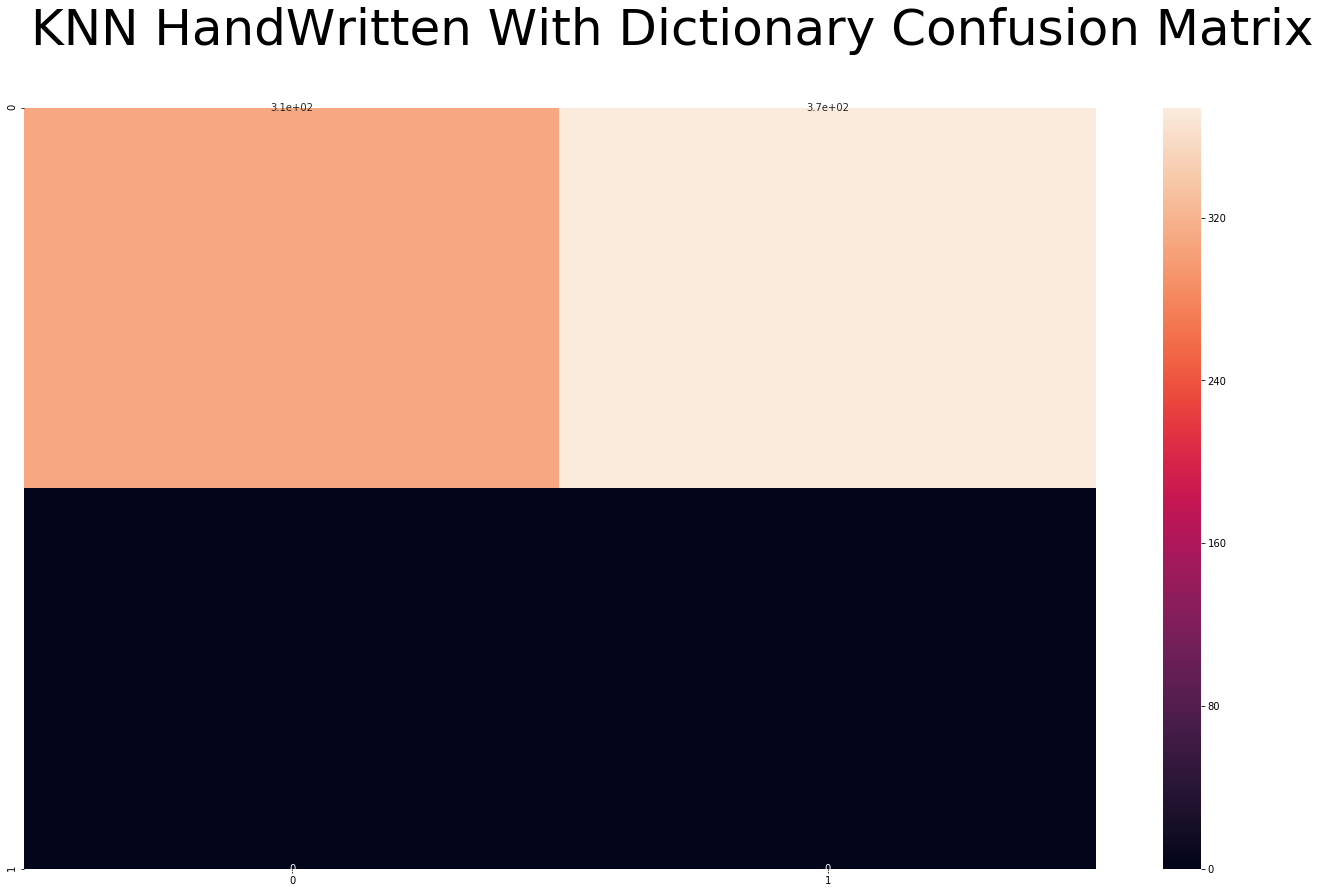

**Accuracy:** 0.4786931818181818


**Precision:** 1.0

**Recall:** 0.4786931818181818

**F1 score:** 0.6474543707973103

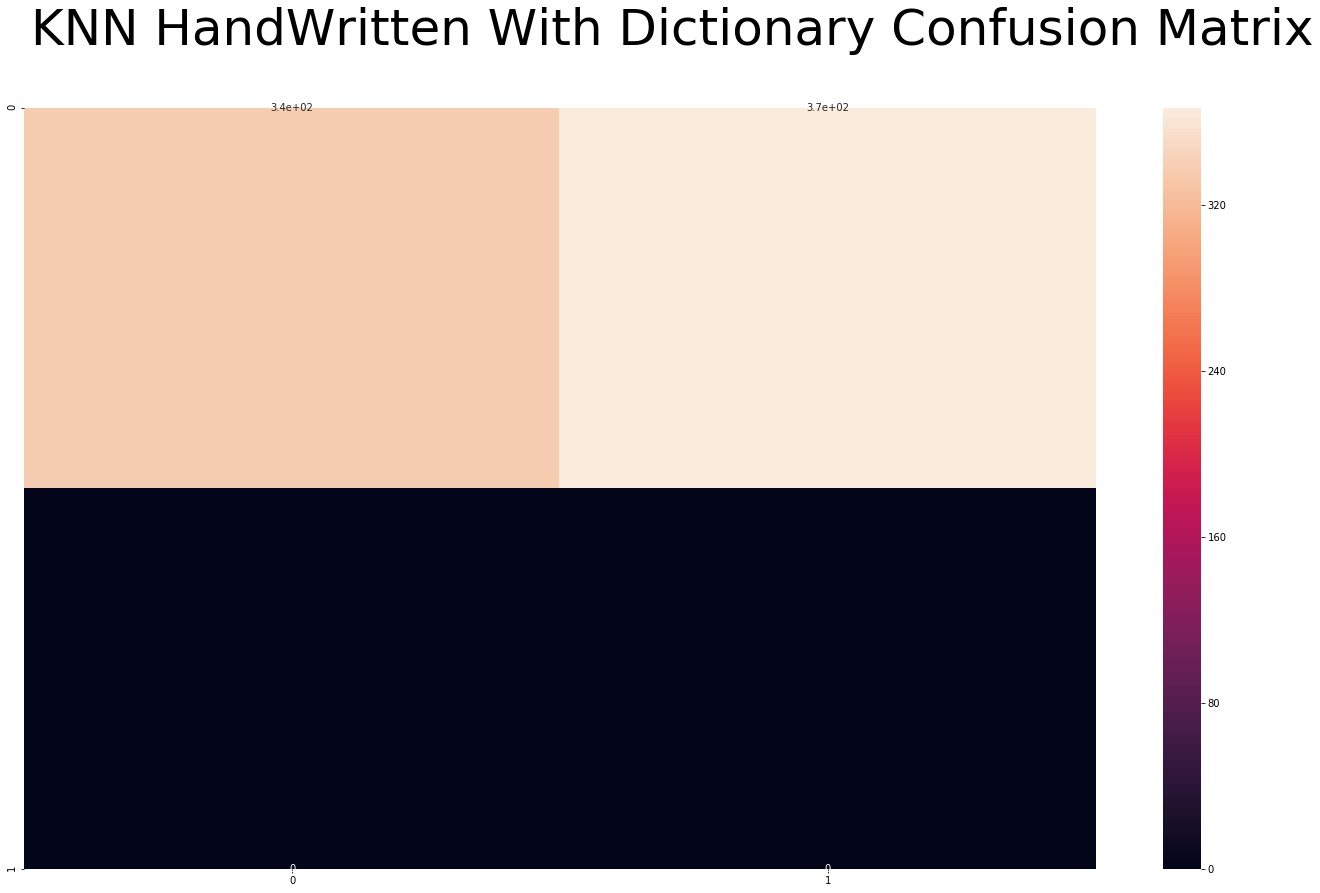

In [7]:
def findModelMetrics(resultArray):
    testAgainst = np.full(len(resultArray),0)
    calculateAccuracyMetrics(resultArray,testAgainst)
    plotConfusionMatrix(resultArray,testAgainst,"KNN HandWritten With Dictionary")

findModelMetrics(noDictionary)
findModelMetrics(dictionary)
